# Prepare text files for each entry
- reference
- Pero OCR
- Tesseract OCR

In [1]:
import os.path

In [2]:
DATASET_PATH = os.path.abspath("../../dataset/supervised")
DATASET_PATH

'/home/joseph/git_github/soduco/paper-ner-bench-das22/dataset/supervised'

In [3]:
ref_path = os.path.join(DATASET_PATH, "10-ref-ocr-ner-json", "all.json")
pero_path = os.path.join(DATASET_PATH, "21-ocr-pero-final", "all.json")
tess_path = os.path.join(DATASET_PATH, "22-ocr-tess-final", "all.json")

## Text file generation

In [4]:
import json
import io

In [5]:
def generate_text_files(json_path, output_dir):
    entries = None
    with open(json_path) as in_file:
        entries = json.load(in_file)
    for entry in entries:
        out_filename = f'{entry["book"]}-{entry["page"]:04d}-{entry["id"]:04d}.txt'
        out_path = os.path.join(output_dir, out_filename)
        text = entry["text_ocr"]
        with io.open(out_path, "wt", encoding="UTF-8", newline='', errors="strict") as file_output:
            file_output.write(text)


In [6]:
for (in_, out) in [(ref_path, "ref"), (pero_path, "pero"), (tess_path, "tess")]:
    out_dir = os.path.join(DATASET_PATH, "80-ocr-text-files", out)
    print(out)
    generate_text_files(in_, out_dir)

ref
pero
tess


## Generate report OCR report

In [7]:
import OCRMetrics
import pandas as pd
import json

with open(ref_path) as f:
    reference = json.load(f)
with open(pero_path) as f:
    pero = json.load(f)
with open(tess_path) as f:
    tess = json.load(f)

uid = lambda x: (x["book"], x["page"], x["id"]) 
ref = { uid(x) : x["text_ocr"] for x in reference }
boxes = { uid(x) : tuple(int(r) for r in x["box"]) for x in reference }
pero = { uid(x) : x["text_ocr"] for x in pero }
tess = { uid(x) : x["text_ocr"] for x in tess }
all_keys = set(ref.keys()) & set(pero.keys()) & set(tess.keys())
valid_keys = set(uid(x) for x in reference if x["valid_box"])

pero_scores = { k : OCRMetrics.align(ref[k], pero[k]) for k in all_keys }
tess_scores = { k : OCRMetrics.align(ref[k], tess[k]) for k in all_keys }

def make_df(scores, index):
    stats = { k : r.stats for k,r in scores.items() }
    data = [ (k[0], k[1], k[2], s.errors, s.reference_length, s.length, index[k]) for k, s in stats.items() ]
    df = pd.DataFrame.from_records(data, columns=["Book", "Page", "Id", "Errors", "RefLength", "Length", "TextPred"] )
    df = df.set_index(["Book", "Page", "Id"])
    return df

pero_df = make_df(pero_scores, pero)
tess_df = make_df(tess_scores, tess)
#all_df = pd.merge(pero_df, tess_df, suffixes=["_pero", "_tess"], how="inner", on=["Book", "Page", "Id"])



Note that dict keys are set-like objects.

In [8]:
# pero.keys?

In [9]:
# Pero and Tess must have the same entries
assert(len(pero.keys() ^ tess.keys()) == 0)

In [10]:
# Pero and Tess must have only valid boxes
assert(pero.keys() == valid_keys)
assert(tess.keys() == valid_keys)

In [11]:
# Pero and Tess must be included in Ref
assert(pero.keys() <= ref.keys())
assert(tess.keys() <= ref.keys())

In [12]:
# Check for duplicate ids
# -> Should be done before

(0.01, 1.0)

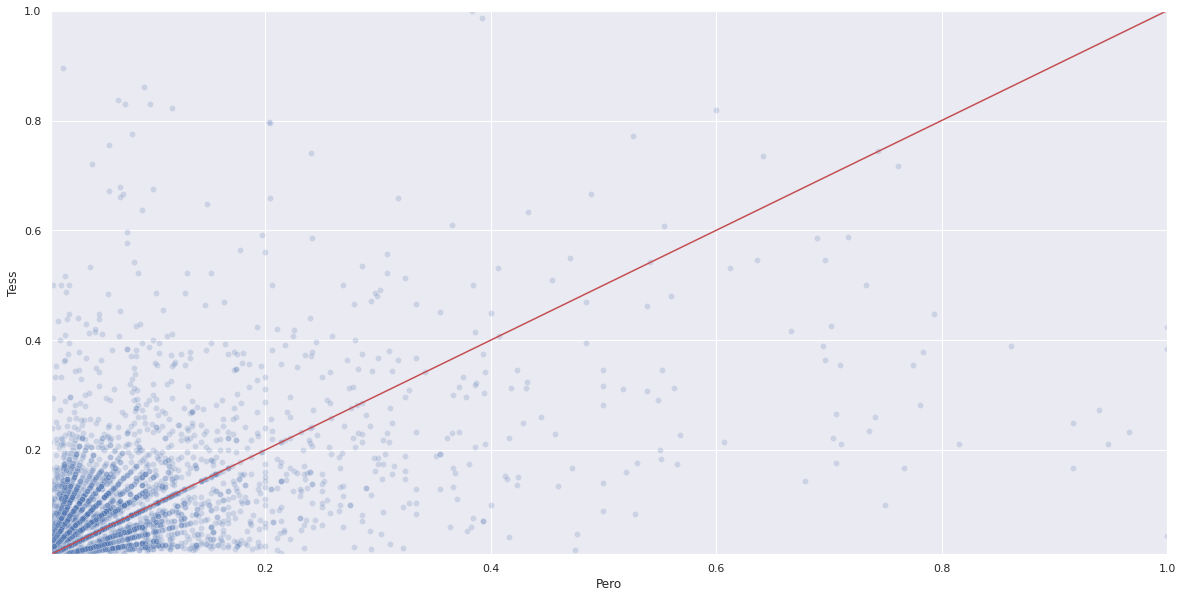

In [13]:
import seaborn as sns
import matplotlib.lines as lines
import matplotlib.pyplot as plt
sns.set_theme()

CER_pero = pero_df["Errors"] / pero_df["RefLength"]
CERnorm_pero = pero_df["Errors"] / pero_df["Length"]
CER_tess = tess_df["Errors"] / tess_df["RefLength"]
CERnorm_tess = tess_df["Errors"] / tess_df["Length"]


uniq_df = pd.DataFrame( data = [ (k[0], k[1], k[2], ref[k], boxes[k]) for k in all_keys ], columns=["Book", "Page", "Id", "TextRef", "Boxes"])
uniq_df = uniq_df.set_index(["Book", "Page", "Id"])

errors = pd.DataFrame( { "Pero": CER_pero, "Tess" : CER_tess , "PeroPred" : pero_df["TextPred"], "TessPred" : tess_df["TextPred"]})
errors = pd.concat([errors, uniq_df], axis=1, join='inner')  

fig, ax = plt.subplots(figsize=(20,10))
fig = sns.scatterplot(data = errors, x = "Pero", y = "Tess", ax=ax, alpha=0.2)
fig.add_artist(lines.Line2D([0, 1], [0, 1], color='r'))
#fig.set_xscale("log")
#fig.set_yscale("log")
fig.set_xlim(0.01, 1)
fig.set_ylim(0.01, 1)

#errors

<AxesSubplot:>

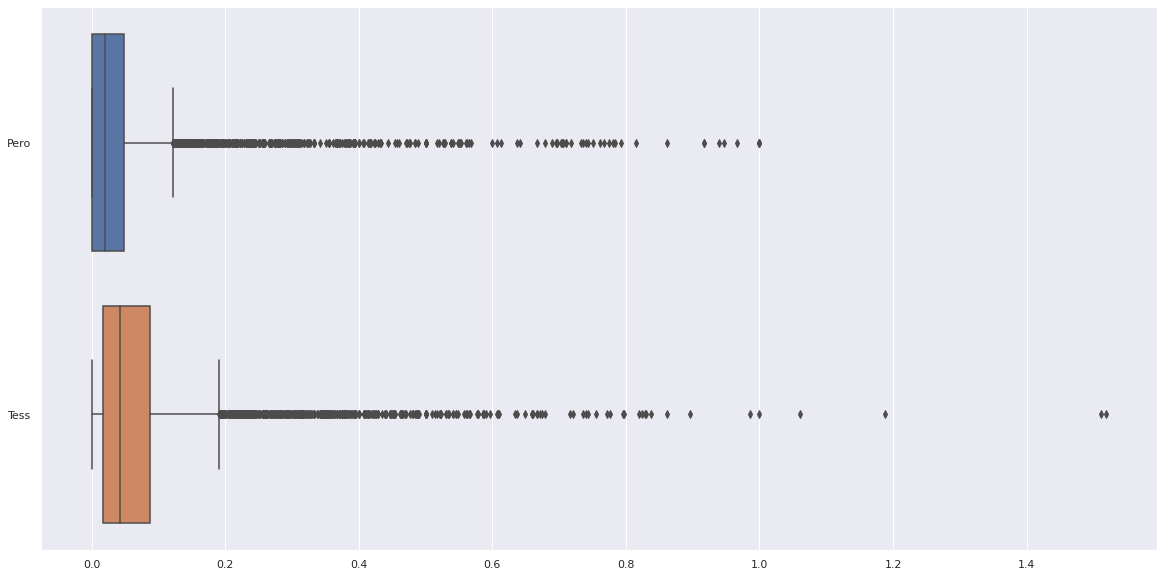

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=errors, orient='h', ax=ax)

In [15]:
byerr = errors.sort_values(by=["Pero"])
byerr[(byerr["Pero"] >= 0.9) | (byerr["Tess"] >= 0.9)]
is_valid = lambda b: b[2] > 50
valid = errors["Boxes"].apply(is_valid)
pd.options.display.float_format = '{:,.2f}'.format
errors[~valid]

,,,Pero,Tess,PeroPred,TessPred,TextRef,Boxes
Book,Page,Id,,,,,,


In [16]:
# errors.loc["Bottin1_1827",117,:].sort_index().loc[520:]

In [17]:
pero_cer = pero_df["Errors"].sum() / pero_df["RefLength"].sum()
tess_cer = tess_df["Errors"].sum() / tess_df["RefLength"].sum()

print("Pero CER: {:.2f}%".format(100 * pero_cer))
print("Tess CER: {:.2f}%".format(100 * tess_cer))
print("Pero Accuracy: {:.2f}%".format(100 * (1 - pero_cer)))
print("Tess Accuracy: {:.2f}%".format(100 * (1 - tess_cer)))

Pero CER: 3.78%
Tess CER: 6.56%
Pero Accuracy: 96.22%
Tess Accuracy: 93.44%


## With ISRI

In [18]:
import isri_tools

In [19]:
def print_report(report):
    for attr in ("characters", "errors", "false_marks", "reject_characters", "suspect_markers"):
        val = getattr(report, attr)
        print(f"{attr:20s}: {val:10d}")
    accuracy = (report.characters - report.errors) / report.characters
    print(f"{'accuracy':20s}: {accuracy*100:10.2f}%")

In [20]:
pero_report = isri_tools.compute_accurary_summary(
    [ref[k] for k in valid_keys], 
    [pero[k] for k in valid_keys]
    )
print_report(pero_report)
# print(pero_report)

characters          :     424764
errors              :      16063
false_marks         :          0
reject_characters   :          0
suspect_markers     :          0
accuracy            :      96.22%


In [21]:
tess_report = isri_tools.compute_accurary_summary(
    [ref[k] for k in valid_keys], 
    [tess[k] for k in valid_keys]
    )
print_report(tess_report)
# print(tess_report)

characters          :     424764
errors              :      27862
false_marks         :          0
reject_characters   :          0
suspect_markers     :          0
accuracy            :      93.44%
